# Etapa 3: Adicionar um pipeline de ML

Nesta etapa, você automatiza o ML workflow de ponta a ponta usando [Amazon SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/) e [Amazon SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html). Você torna a engenharia de features reutilizável, repetível e escalável usando o [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/).

![](img/seis-etapas-3.png)

<div class="alert alert-info"> Certifique-se de que está usando o kernel <code>Python 3</code> no JupyterLab para este notebook.</div>

<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
    <text x="100" y="56" font-family="Arial, sans-serif" font-size="14" fill="#333333">Você pode ignorar com segurança as mensagens de aviso.</text>
</svg>

In [1]:
#  Para obter o módulo Feature Processor, precisamos reinstalar o SDK python do SageMaker junto com dependências extras#
%pip install 'sagemaker[feature-processor]' --force-reinstall

  Using cached sagemaker-2.232.2-py3-none-any.whl.metadata (16 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached boto3-1.35.40-py3-none-any.whl.metadata (6.7 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl.metadata (6.9 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached importlib_metadata-6.11.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pathos-0.3.3-py3-none-any.whl.metadata (11 kB)
  Using cached platformdirs-4.3.6-py3-none-any.whl.metadata (11 kB)
  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x

In [2]:
%pip install -q s3fs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.20.0 requires faiss-cpu<=1.8.0, which is not installed.
datasets 2.21.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.3.9 which is incompatible.
datasets 2.21.0 requires fsspec[http]<=2024.6.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires psutil~=5.9, but you have psutil 6.0.0 which is incompatible.
boto3 1.35.40 requires botocore<1.36.0,>=1.35.40, but you have botocore 1.34.131 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import pandas as pd
import json
import boto3
import pathlib
import io
import sagemaker
import mlflow
from time import gmtime, strftime, sleep
from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer

from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    ScriptProcessor
)
from sagemaker.inputs import TrainingInput

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import (
    ProcessingStep, 
    TrainingStep, 
    CreateModelStep,
    CacheConfig
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.quality_check_step import (
    DataQualityCheckConfig,
    ModelQualityCheckConfig,
    QualityCheckStep,
)
from sagemaker.workflow.clarify_check_step import (
    ModelBiasCheckConfig, 
    ClarifyCheckStep, 
    ModelExplainabilityCheckConfig
)
from sagemaker import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.conditions import (
    ConditionGreaterThan,
    ConditionGreaterThanOrEqualTo
)
from sagemaker.workflow.parallelism_config import ParallelismConfiguration
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import (
    Join,
    JsonGet
)
from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.model_metrics import (
    MetricsSource, 
    ModelMetrics, 
    FileSource
)
from sagemaker.drift_check_baselines import DriftCheckBaselines
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig 
from sagemaker.image_uris import retrieve
from sagemaker.workflow.function_step import step
from sagemaker.workflow.step_outputs import get_step
from sagemaker.model_monitor import DatasetFormat, model_monitoring

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.232.2'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERRO] VOCÊ PRECISA EXECUTAR o notebook 00-inicie-aqui")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")


Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
bucket_name                            -> 'sagemaker-us-east-1-533267005474'
bucket_prefix                          -> 'from-idea-to-prod/xgboost'
dataset_file_local_path                -> 'data/bank-additional/bank-additional-full.csv'
domain_id                              -> 'd-j2g52sky4w9s'
evaluation_s3_url                      -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
experiment_name                        -> 'from-idea-to-prod-experiment-14-22-54-53'
initialized                            -> True
input_s3_url                           -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
mlflow_arn                             -> 'arn:aws:sagemaker:us-east-1:533267005474:mlflow-t
mlflow_name                            -> 'mlflow-d-j2g52sky4w9s-14-22-19-50'
model_package_group_name               -> 'from-idea-to-prod-pipeline-model-14-22

## Definir constantes



In [14]:
# Definir nomes dos objetos do pipeline, experimento e modelo

project = "from-idea-to-prod"

current_timestamp = strftime('%d-%H-%M-%S', gmtime())

registered_model_name = f"{project}-pipeline-model-{current_timestamp}"
experiment_name = f"{project}-pipeline-{current_timestamp}"
pipeline_name = f"{project}-pipeline-{current_timestamp}"
pipeline_model_name = f"{project}-model-xgb"
model_package_group_name = registered_model_name
endpoint_config_name = f"{project}-endpoint-config"
endpoint_name = f"{project}-endpoint"
model_approval_status = "PendingManualApproval"

In [15]:
# Definir tipos e contagens de instâncias

process_instance_type = "ml.m5.large"
train_instance_type = "ml.m5.large"

In [16]:
# Definir URLs do S3 para vários conjuntos de dados produzidos no pipeline

output_s3_prefix = f"s3://{bucket_name}/{bucket_prefix}"
output_s3_url = f"{output_s3_prefix}/output"

train_s3_url = f"{output_s3_prefix}/train"
validation_s3_url = f"{output_s3_prefix}/validation"
test_s3_url = f"{output_s3_prefix}/test"
evaluation_s3_url = f"{output_s3_prefix}/evaluation"

baseline_s3_url = f"{output_s3_prefix}/baseline"
baseline_results_s3_url = f"{baseline_s3_url}/results"

prediction_baseline_s3_url = f"{output_s3_prefix}/prediction_baseline"
prediction_baseline_results_s3_url=f"{prediction_baseline_s3_url}/results"

In [17]:
XGBOOST_IMAGE_URI = sagemaker.image_uris.retrieve(
            "xgboost", 
            region=boto3.Session().region_name,
            version="1.7-1"
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [18]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url
%store pipeline_name
%store model_package_group_name
%store evaluation_s3_url
%store prediction_baseline_s3_url
%store output_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)
Stored 'pipeline_name' (str)
Stored 'model_package_group_name' (str)
Stored 'evaluation_s3_url' (str)
Stored 'prediction_baseline_s3_url' (str)
Stored 'output_s3_url' (str)


In [19]:
print(f"Train S3 url: {train_s3_url}")
print(f"Validation S3 url: {validation_s3_url}")
print(f"Test S3 url: {test_s3_url}")
print(f"Data baseline S3 url: {baseline_s3_url}")
print(f"Evaluation metrics S3 url: {evaluation_s3_url}")
print(f"Model prediction baseline S3 url: {prediction_baseline_s3_url}")

Train S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/train
Validation S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/validation
Test S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test
Data baseline S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/baseline
Evaluation metrics S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/evaluation
Model prediction baseline S3 url: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/prediction_baseline


## Definir funções auxiliares
Defina algumas funções abreviadas para melhor legibilidade do código.

In [20]:
def get_xgb_estimator(
    session,
    instance_type,
    output_s3_url,
    base_job_name,
):
    """
    Cria e configura um estimador XGBoost para o SageMaker.

    Args:
        session (sagemaker.session.Session): Objeto de sessão do SageMaker.
        instance_type (str): Tipo de instância EC2 para treinamento.
        output_s3_url (str): URL S3 para armazenar artefatos de saída.
        base_job_name (str): Nome base para o job de treinamento no SageMaker.

    Returns:
        sagemaker.estimator.Estimator: Objeto estimador XGBoost configurado.

    Esta função cria um estimador SageMaker para XGBoost e define seus hiperparâmetros.
    O estimador é configurado com o tipo de instância, local de saída e nome de job especificados.
    """
    # Instanciar um objeto estimador XGBoost
    estimator = sagemaker.estimator.Estimator(
        image_uri=XGBOOST_IMAGE_URI,
        role=sagemaker.get_execution_role(), 
        instance_type=instance_type,
        instance_count=1,
        output_path=output_s3_url,
        sagemaker_session=session,
        base_job_name=base_job_name
    )
    
    # Definir hiperparâmetros do algoritmo
    estimator.set_hyperparameters(
        num_round=100,              # Número de rodadas de boosting para treinamento
        max_depth=3,                # Profundidade máxima de uma árvore
        eta=0.5,                    # Taxa de aprendizado, controla o tamanho do passo na descida do gradiente
        alpha=2.5,                  # Termo de regularização L1 nos pesos
        objective="binary:logistic", # Função objetivo para classificação binária
        eval_metric="auc",          # Métrica de avaliação para dados de validação
        subsample=0.8,              # Fração de amostras usadas para treinar cada árvore
        colsample_bytree=0.8,       # Fração de features usadas para treinar cada árvore
        min_child_weight=3,         # Soma mínima do peso da instância necessária em um nó filho
        early_stopping_rounds=10,   # Número de rodadas sem melhoria antes de parar precocemente
        verbosity=1,                # Nível de detalhamento para registro de log
    )

    return estimator

## Configurar MLflow

In [21]:
# Verificar se o servidor MLflow está no status 'Created'
sm = boto3.client("sagemaker")

while sm.describe_mlflow_tracking_server(TrackingServerName=mlflow_name)['TrackingServerStatus'] != 'Created':
    print(f"O servidor MLflow {mlflow_name} não está no status 'Created'")
    sleep(30)
else:
    print(f"Usando o servidor {mlflow_name}")


Usando o servidor mlflow-d-j2g52sky4w9s-14-22-19-50


In [22]:
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

2024/10/15 02:09:09 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-pipeline-15-02-08-59' does not exist. Creating a new experiment.


## Configurar padrões para a infraestrutura AWS
Você pode usar um arquivo de configuração YAML para definir os valores padrão que são automaticamente passados para as APIs do SageMaker, por exemplo, como parâmetros de job. É especialmente conveniente quando você precisa fornecer parâmetros estáticos para configurações de infraestrutura, como ids de VPC, Grupos de Segurança, chaves KMS etc., ou trabalhar com funções remotas.

Consulte a documentação [Configurando e usando padrões com o SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk) para exemplos e mais detalhes.

Seu pipeline SageMaker usará esses arquivos `config.yaml`.

In [23]:
# Print localização padrão dos arquivos de configuração
import os
from platformdirs import site_config_dir, user_config_dir

#Prints a localização do arquivo de configuração do administrador
print(os.path.join(site_config_dir("sagemaker"), "config.yaml"))

#Prints a localização do arquivo de configuração do usuário
print(os.path.join(user_config_dir("sagemaker"), "config.yaml"))

/etc/xdg/sagemaker/config.yaml
/home/sagemaker-user/.config/sagemaker/config.yaml


A próxima célula cria um arquivo de configuração e define valores padrão para funções remotas. Esses valores são automaticamente passados para o decorador `@step` e você não precisa especificá-los explicitamente. Consulte [Configure seu pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-cfg-pipeline.html) no Guia do Desenvolvedor.

In [24]:
%%writefile config.yaml

SchemaVersion: '1.0'
SageMaker:
    PythonSDK:
        Modules:
            RemoteFunction:
                InstanceType: ml.m5.xlarge
                Dependencies: ./requirements.txt
                IncludeLocalWorkDir: true
                CustomFileFilter:
                    IgnoreNamePatterns: # arquivos ou diretórios a serem ignorados
                        - "*.ipynb" # todos os arquivos de notebook
                        - "*.md" # todos os arquivos markdown
                        - "__pycache__"

Writing config.yaml


In [25]:
# copiar o arquivo de configuração para o local do arquivo de configuração do usuário
%mkdir -p {user_config_dir("sagemaker")}
%cp config.yaml {os.path.join(user_config_dir("sagemaker"), "config.yaml")}

## Preparar ambiente

In [26]:
# Instalar xgboost para o teste local do código
%pip install -q xgboost

Note: you may need to restart the kernel to use updated packages.


Crie um arquivo `requirement.txt` para o ambiente do pipeline que será usado pelo seu pipeline SageMaker:



In [28]:
%%writefile requirements.txt
scikit-learn
pandas>=2.0.0
s3fs==0.4.2
sagemaker
xgboost
mlflow==2.13.2
sagemaker-mlflow==0.1.0

Overwriting requirements.txt


## Um pipeline SageMaker

### Configurar parâmetros do pipeline
O SageMaker Pipelines suporta [parametrização](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html), que permite especificar parâmetros de entrada em tempo de execução sem alterar o código do seu pipeline. Você pode usar as classes de parâmetros disponíveis no módulo [`sagemaker.workflow.parameters`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#parameters).
Os parâmetros têm um valor padrão, que você pode substituir especificando valores de parâmetro ao iniciar uma execução do pipeline.

In [29]:
# Definir tipo de instância de processamento
process_instance_type_param = ParameterString(
    name="ProcessingInstanceType",
    default_value=process_instance_type,
)

# Definir tipo de instância de treinamento
train_instance_type_param = ParameterString(
    name="TrainingInstanceType",
    default_value=train_instance_type,
)

# Definir status de aprovação do modelo para o registro de modelos
model_approval_status_param = ParameterString(
    name="ModelApprovalStatus",
    default_value=model_approval_status
)

# Mínimo threshold fpara o desempenho do modelo no conjunto de dados de teste
test_score_threshold_param = ParameterFloat(
    name="TestScoreThreshold",
    default_value=0.75
)

# Parametrizar a URL S3 para o conjunto de dados de entrada
input_s3_url_param = ParameterString(
    name="InputDataUrl",
    default_value=input_s3_url,
)

# Nome do grupo de pacotes de modelo
model_package_group_name_param = ParameterString(
    name="ModelPackageGroupName",
    default_value=model_package_group_name,
)

# ARN do servidor de rastreamento MLflow
tracking_server_arn_param = ParameterString(
    name="TrackingServerARN",
    default_value=mlflow_arn,
)

### Implemente e teste etapas do pipeline
Você cria um pipeline com o seguinte:

| Passo | Descrição |
|---|---|
| **Data processing** | executa um job de processamento do SageMaker para feature engineering e divisão do conjunto de dados|
| **Training** | executa um job de treinamento do SageMaker usando o algoritmo XGBoost |
| **Evaluation** | avalia o desempenho do modelo treinado |
| **Conditional step** | verifica se o desempenho do modelo atende ao threshold especificado |
| **Register model** | registra uma versão do modelo no registro de modelos do SageMaker |

Para facilitar a implementação do seu pipeline como código, você vai usar duas features úteis do SageMaker: Compatibilidade de subclasse e decorador @step.

#### Compatibilidade de subclasse
💡 Você pode usar a compatibilidade de subclasse para [etapas de job do pipeline de fluxo de job](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#steps) para criar abstrações de job e usar exatamente o mesmo código para configurar o pipeline que o código para executar jobs de processamento, treinamento, transformação e ajuste dos notebooks de etapas anteriores. Você precisa usar o contexto [PipelineSession](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) em vez de `sagemaker_session` para capturar as chamadas de execução como `processor.run()` ou `estimator.fit()`, mas não executar até que o pipeline seja criado e executado.

#### Decorador @step
💡 Você pode transferir seu código Python existente para pipelines SageMaker. Você também pode usar funções Python para implementar ML workflow usando o SDK Python do SageMaker e testar todo o código localmente no notebook. Quando você quiser criar um pipeline, pode usar o decorador [`@step`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#step-decorator) do SDK Python do SageMaker para converter funções Python em etapas do pipeline. Consulte o [Guia do Desenvolvedor](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html) do SageMaker para mais detalhes e exemplos.

O código a seguir usa funções Python para implementar etapas do fluxo de job, testá-las localmente e, em seguida, aplica o decorador `@step` para reutilizar a função como uma etapa do pipeline.

#### Limitações com o decorador @step
Esteja ciente das [limitações](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-limit.html) específicas ao usar o decorador `@step` para etapas do pipeline.

Inicie o desenvolvimento e os testes nos passos a seguir nas células de código.

#### Etapa de processamento
Reutilize o código local da função Python do notebook da etapa 2 [notebook](./02-sagemaker-containers.ipynb) e crie uma função `preprocess` na pasta `./pipeline_steps`. Você vai usar essa função para criar uma etapa de processamento do pipeline.

In [30]:
# O código da função Python está nos arquivos locais
from pipeline_steps.preprocess import preprocess

In [31]:
# Ver o código da função
!pygmentize pipeline_steps/preprocess.py

import pandas as pd
import numpy as np
import mlflow
from mlflow.data.pandas_dataset import PandasDataset
from time import gmtime, strftime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def preprocess(
    input_data_s3_path,
    output_s3_prefix,
    tracking_server_arn,
    experiment_name=None,
    pipeline_run_name=None,
    run_id=None,
):
    try:
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_tracking_uri(tracking_server_arn)
        experiment = mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"{preprocess.__name__ }-{suffix}")
        pipeline_run = mlflow.start_run(run_name=pipeline_run_name) if pipeline_run_name else None            
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"processing-{suffix}", nested=True)

        # Carregar dados
        df_data = pd.read_csv(input_data_s3_path, sep=";")

        input_dataset = mlflow.data.from_pandas(df_data, source=inpu

In [32]:
# verificar se há um conjunto de dados sob a URL S3
!aws s3 ls {input_s3_url}

2024-10-15 02:00:36    5834924 bank-additional-full.csv


In [33]:
# Você pode executar seu código Python localmente e verificar a correção antes de construir um pipeline
r_preprocess = preprocess(
    input_data_s3_path=input_s3_url,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=mlflow_arn,
    experiment_name=f"local-test-{current_timestamp}"
)
r_preprocess

2024/10/15 02:11:36 INFO mlflow.tracking.fluent: Experiment with name 'local-test-15-02-08-59' does not exist. Creating a new experiment.
/opt/conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/input/bank-additional-full.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles 

## Divisão de dados > treino:(28831, 65) | validação:(8238, 65) | teste:(4119, 65)


2024/10/15 02:12:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run processing-15-02-11-36 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13/runs/9b705b90067b4e64a9ba07e928e7da18.
2024/10/15 02:12:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13.


## Processamento de dados concluído. Saindo.


{'train_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/train/train.csv',
 'validation_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/validation/validation.csv',
 'test_x_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_x.csv',
 'test_y_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_y.csv',
 'baseline_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/baseline/baseline.csv',
 'experiment_name': 'local-test-15-02-08-59',
 'pipeline_run_id': ''}

In [34]:
# verificar se a função gerou saída

!aws s3 ls {output_s3_prefix}/test/

2024-10-15 02:12:00     600465 test_x.csv
2024-10-15 02:11:59       8238 test_y.csv


#### Etapa de treinamento
Primeiro, execute um treinamento de modelo remotamente como um job de treinamento de algoritmo integrado do SageMaker.

Segundo, use o modelo treinado para testar o script de avaliação como uma função Python local.

Terceiro, use esta função Python para construir uma etapa de avaliação no pipeline.

In [35]:
# use sagemaker.Session() no estimador para iniciar um job de treinamento imediatamente
estimator = get_xgb_estimator(
    session=sagemaker.Session(),
    instance_type=train_instance_type,
    output_s3_url=output_s3_url,
    base_job_name=f"{project}-train",
)

In [36]:
# Configure as entradas de treinamento usando as saídas da função de pré-processamento

training_inputs = {
    "train": TrainingInput(
        r_preprocess['train_data'],
        content_type="text/csv",
    ),
    "validation": TrainingInput(
        r_preprocess['validation_data'],
        content_type="text/csv",
    ),
}

A próxima célula de código ajusta o estimador. Aguarde menos de 3 minutos até que o job de treinamento termine. Observe que o código também registra o modelo treinado na execução do experimento MLflow.

In [38]:
from pipeline_steps.evaluate import load_model

# Executa o job de treinamento

mlflow.set_experiment(r_preprocess['experiment_name'])
with mlflow.start_run(
    run_name=f"training-{strftime('%d-%H-%M-%S', gmtime())}",
    description="treinamento no notebook 03 com um job de treinamento") as run:
    mlflow.log_params(estimator.hyperparameters())
    
    estimator.fit(training_inputs)

    mlflow.log_param("nome do job de treinamento", estimator.latest_training_job.name)
    mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in estimator.training_job_analytics.dataframe().iloc})
    mlflow.xgboost.log_model(load_model(estimator.model_data), artifact_path="xgboost")

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-train-2024-10-15-02-18-02-267


2024-10-15 02:18:05 Starting - Starting the training job...
2024-10-15 02:18:20 Starting - Preparing the instances for training...
2024-10-15 02:18:47 Downloading - Downloading input data...
2024-10-15 02:19:33 Downloading - Downloading the training image......
2024-10-15 02:20:39 Training - Training image download completed. Training in progress...[2024-10-15 02:20:41.809 ip-10-0-101-56.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-15 02:20:41.832 ip-10-0-101-56.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-15:02:20:42:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-15:02:20:42:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2024-10-15:02:20:42:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-10-15:02:20:42:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-15:02:20:42:I

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [02:21:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2024/10/15 02:21:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/15 02:21:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run training-15-02-18-01 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13/runs/b7d6ee9755144f178a572350d80747db.
2024/10/15 02:21:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13.


#### Etapa de avaliação
Crie um script de avaliação do modelo como uma função Python local para verificar se o desempenho do modelo atende ao threshold especificado. O código Python está no arquivo `evaluate.py` na pasta `./pipeline_steps`.

In [39]:
from pipeline_steps.evaluate import evaluate

In [40]:
# !pygmentize  pipeline_steps/evaluation.py

In [41]:
#  verifique se o job de treinamento que você acabou de executar criou um arquivo de modelo
!aws s3 ls {estimator.model_data}

2024-10-15 02:20:58       4963 model.tar.gz


Agora carregue o modelo treinado no script de avaliação e verifique se o script é executado corretamente. Observe o uso dos parâmetros de saída da função `preprocess` e do artefato do modelo do job de treinamento.

2024/10/15 02:21:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run evaluate-15-02-21-41 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13/runs/d24c33416184479f9a888fde9830a627.
2024/10/15 02:21:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13.


{'evaluation_result': {'classification_metrics': {'auc_score': {'value': 0.7701863354037267}}},
 'prediction_baseline_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/prediction_baseline/prediction_baseline.csv',
 'experiment_name': 'local-test-15-02-08-59',
 'pipeline_run_id': ''}

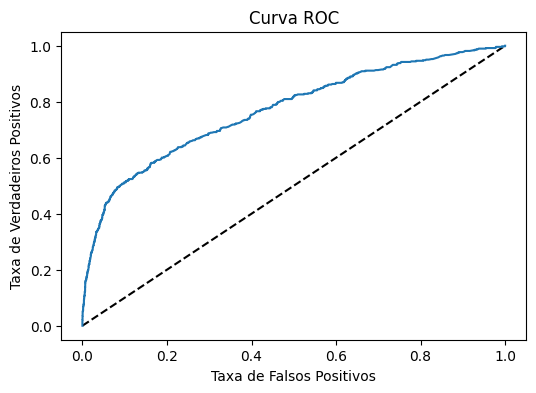

In [42]:
# Execute o codigo de avaliação localmente
r_eval = evaluate(
    test_x_data_s3_path=r_preprocess['test_x_data'],
    test_y_data_s3_path=r_preprocess['test_y_data'],
    model_s3_path=estimator.model_data,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=mlflow_arn,
    experiment_name=r_preprocess['experiment_name'],
)
r_eval

In [43]:
# Verificar se a função de avaliação gerou saída
!aws s3 ls {output_s3_prefix}/prediction_baseline/

2024-10-15 02:21:43      62730 prediction_baseline.csv


#### Etapa de registro do modelo
A etapa de registro cria um modelo SageMaker e registra uma nova versão de um modelo no SageMaker Model Registry dentro de um [grupo de pacotes de modelo](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-model-group.html). 
Você implementa esta etapa também como uma função Python local. O código é fornecido no arquivo `register.py` na pasta `./pipeline_steps`.

In [44]:
from pipeline_steps.register import register

In [45]:
# !pygmentize  pipeline_steps/register.py

In [47]:
# Execute o código de registro do modelo localmente

r_register = register(
    training_job_name=estimator.latest_training_job.name,
    model_package_group_name=model_package_group_name,
    model_approval_status=model_approval_status,
    evaluation_result=r_eval['evaluation_result'],
    output_s3_prefix=output_s3_url,
    tracking_server_arn=mlflow_arn,
    experiment_name=r_preprocess['experiment_name'],
)
r_register


2024-10-15 02:21:02 Starting - Preparing the instances for training
2024-10-15 02:21:02 Downloading - Downloading the training image
2024-10-15 02:21:02 Training - Training image download completed. Training in progress.
2024-10-15 02:21:02 Uploading - Uploading generated training model
2024-10-15 02:21:02 Completed - Training job completed


2024/10/15 02:22:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run register-15-02-22-11 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13/runs/4475d7fee18d4d8a82d1dee73a695a46.
2024/10/15 02:22:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/13.


{'model_package_arn': 'arn:aws:sagemaker:us-east-1:533267005474:model-package/from-idea-to-prod-pipeline-model-15-02-08-59/2',
 'model_package_group_name': 'from-idea-to-prod-pipeline-model-15-02-08-59',
 'pipeline_run_id': ''}

In [48]:
# verifique se uma nova versão do modelo foi registrada no grupo de pacotes de modelo
boto3.client('sagemaker').describe_model_package(ModelPackageName=r_register['model_package_arn'])

{'ModelPackageGroupName': 'from-idea-to-prod-pipeline-model-15-02-08-59',
 'ModelPackageVersion': 2,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:533267005474:model-package/from-idea-to-prod-pipeline-model-15-02-08-59/2',
 'CreationTime': datetime.datetime(2024, 10, 15, 2, 22, 20, 824000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
    'ImageDigest': 'sha256:ba417ec6d8d3e0c6b5f463bc9202e3b498b42260a29b61875f34beb6d99d8444',
    'ModelDataUrl': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/output/from-idea-to-prod-train-2024-10-15-02-18-02-267/output/model.tar.gz',
    'Environment': {}}],
  'SupportedTransformInstanceTypes': ['ml.m5.xlarge', 'ml.m5.large'],
  'SupportedRealtimeInferenceInstanceTypes': ['ml.m5.xlarge', 'ml.m5.large'],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPa

### Construir um pipeline
Após o teste local, você pode usar o mesmo código Python sem alterações para construir um pipeline.

A próxima célula cria um pipeline com as etapas previamente desenvolvidas e testadas. Observe que você mistura funções decoradas com `@step` (preprocess, evaluate, register) e etapas tradicionais do pipeline (train) como jobs do SageMaker no mesmo pipeline e passa dados entre eles.

Você não precisa definir manualmente uma ordem das etapas, pois o SageMaker deriva automaticamente o fluxo de processamento com base nas dependências de dados entre as etapas do pipeline. Você também não precisa gerenciar a transferência de artefatos e conjuntos de dados de uma etapa do pipeline para outra, porque o SageMaker cuida automaticamente do fluxo de dados.

Observe o uso de [`PipelineSession`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) em vez de Session no objeto estimator para a etapa de treinamento. Ao construir um pipeline, um objeto PipelineSession deve ser fornecido ao construtor de `Estimator` ou `Processor` para iniciar o job no momento da execução do pipeline e não imediatamente como com a `Session` do SageMaker.


In [49]:
# Etapa de pré-processamento de dados
step_preprocess = step(
    preprocess, 
    instance_type=process_instance_type_param,
    name=f"{project}-preprocess",
    keep_alive_period_in_seconds=3600,
)(
    input_data_s3_path=input_s3_url_param,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=experiment_name,
    pipeline_run_name=ExecutionVariables.PIPELINE_EXECUTION_ID,
)

cache_config = CacheConfig(
        enable_caching=True,
        expire_after="P30d" # 30-day
    )

# Etapa de treinamento
step_train = TrainingStep(
    name=f"{project}-train",
    step_args=get_xgb_estimator(
        session=PipelineSession(),
        instance_type=train_instance_type_param,
        output_s3_url=output_s3_url,
        base_job_name=f"{project}-train",
    ).fit(
        {
            "train": TrainingInput(
                step_preprocess['train_data'],
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                step_preprocess['validation_data'],
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)    

# Etapa de avaliação
step_evaluate = step(
    evaluate,
    instance_type=process_instance_type_param,
    name=f"{project}-evaluate",
    keep_alive_period_in_seconds=3600,
)(
    test_x_data_s3_path=step_preprocess['test_x_data'],
    test_y_data_s3_path=step_preprocess['test_y_data'],
    model_s3_path=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=step_preprocess['experiment_name'],
    pipeline_run_id=step_preprocess['pipeline_run_id'],
)

# Etapa de registro do modelo
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        experiment_name=step_preprocess['experiment_name'],
        pipeline_run_id=step_preprocess['pipeline_run_id'],
    )

# Etapa de falha (caso a condição não seja atendida)
step_fail = FailStep(
    name=f"{project}-fail",
    error_message=Join(on=" ", values=["Execution failed due to AUC Score < ", test_score_threshold_param]),
)

# condição para verificar na etapa de condição

condition_gte = ConditionGreaterThanOrEqualTo(
        left=step_evaluate['evaluation_result']['classification_metrics']['auc_score']['value'],  
        right=test_score_threshold_param,
)

# etapa de registro condicional

step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register],
    else_steps=[step_fail],
)

# cria um objeto Pipeline com todas essas etapas e parâmetros definidos. O pipeline inclui configurações para cache, tipos de instância, 
# aprovação do modelo, limiar de pontuação de teste, entre outros.

pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[
        input_s3_url_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


Observe que adicionamos mais duas etapas ao pipeline: Etapa de Falha e Etapa de Condição.

#### Etapa de Falha
Uma [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) do Pipelines interrompe a execução do pipeline se a métrica de desempenho do modelo não atender ao limiar especificado.

#### Etapa de Condição
A etapa de condição verifica a pontuação de desempenho do modelo calculada na etapa de avaliação e, condicionalmente, cria um modelo e o registra no registro de modelos, ou interrompe e falha a execução do pipeline.

#### Atualizar o pipeline
Agora crie o pipeline. Se um pipeline com o mesmo nome já existir, o SageMaker irá atualizá-lo.

Você precisa passar apenas a última etapa para o construtor `Pipeline`. O SDK constrói automaticamente um DAG (Grafo Acíclico Direcionado) do pipeline com base nas dependências de dados entre as etapas. Consulte o [Guia do Desenvolvedor](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html#pipelines-step-define-delayed) para mais detalhes.

In [50]:
# A operação de upsert serializa o código da função, argumentos e outros artefatos para o S3, onde podem ser acessados durante a execução do pipeline
pipeline.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-10-15 02:22:56,629 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-22-53-747/function
2024-10-15 02:22:56,724 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-22-53-747/arguments
2024-10-15 02:22:57,082 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp4zxakcl2/requirements.txt'
2024-10-15 02:22:57,109 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-22-53-747/pre_exec_script_and_dependencies'
2024-10-15 02:22:57,343 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 02:23:04,150 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-22-53-747/function
2024-10-15 02:23:04,259 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-22-53-747/arguments
2024-10-15 02:23:04,328 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpv3iz42t5/requirements.txt'
2024-10-15 02:23:04,360 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-22-53-747/pre_exec_script_and_dependencies'


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 02:23:06,920 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-22-53-747/function
2024-10-15 02:23:07,054 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-22-53-747/arguments
2024-10-15 02:23:07,141 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp5pxvy6yl/requirements.txt'
2024-10-15 02:23:07,167 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-22-53-747/pre_exec_script_and_dependencies'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59',
 'ResponseMetadata': {'RequestId': '1bb28703-f6ba-458d-91e3-8ac98fddbd31',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1bb28703-f6ba-458d-91e3-8ac98fddbd31',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Tue, 15 Oct 2024 02:23:08 GMT'},
  'RetryAttempts': 0}}

Para ver o pipeline criado na interface do Studio, clique no link construído pela célula de código abaixo:


In [51]:
from IPython.display import HTML

# Monstre o link da pipeline
display(
    HTML('<b>Veja <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/graph">a pipeline</a> no Studio UI</b>'.format(
            domain_id, region, pipeline_name))
)

Com base nas dependências de dados entre as etapas do pipeline, o SageMaker constrói o seguinte DAG (Grafo Acíclico Direcionado) com o fluxo de dados em seu pipeline:
![](img/pipeline-graph.png)

### Executar o pipeline
A primeira execução do pipeline leva cerca de 17-20 minutos. Observe o uso do parâmetro `keep_alive_period_in_seconds` na definição da etapa para a reutilização do pool quente e `CacheConfig` na etapa de Treinamento para o cache dos resultados da etapa.
Uma execução subsequente do pipeline leva cerca de 7 minutos devido ao uso de cache e um pool quente.

In [52]:
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59/execution/lom75sci1bml',
 'PipelineExecutionDisplayName': 'execution-1728959098018',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 10, 15, 2, 24, 57, 908000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 15, 2, 24, 57, 908000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:533267005474:user-profile/d-j2g52sky4w9s/default-20241011T175458',
  'UserProfileName': 'default-20241011T175458',
  'DomainId': 'd-j2g52sky4w9s',
  'IamIdentity': {'Arn': 'arn:aws:sts::533267005474:assumed-role/AmazonSageMaker-ExecutionRole-20241011T175459/SageMaker',
   'PrincipalId': 'AROAXYKJQYARJCTS7QXYB:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:533267005474:user-p

In [53]:
# Descomente se você quiser esperar no notebook até que esta execução seja concluída
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[{'StepName': 'from-idea-to-prod-preprocess',
  'StartTime': datetime.datetime(2024, 10, 15, 2, 24, 58, 726000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:533267005474:training-job/preprocess-lom75sci1bml-xpQ5EKx4EU'}},
  'AttemptCount': 1}]

Você pode ver a execução do pipeline na interface do Studio clicando no link construído pela seguinte célula de código:

In [55]:
# Mostrar o link de execução do pipeline
display(
    HTML('<b>Veja <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/executions/{}/graph">a pipeline de execução</a> no Studio UI</b>'.format(
            domain_id, region, pipeline_name, pipeline_execution.describe()['PipelineExecutionArn'].split('/')[-1]))
)

Para gerenciar pipelines na interface do Studio, selecione **Pipelines** no menu de navegação à esquerda e, em seguida, o pipeline específico para ver as execuções do pipeline e todos os detalhes:

![](img/pipelines-pane.png)

Para cada execução, você pode abrir um gráfico de execução e ver detalhes de cada etapa do pipeline:

![](img/pipeline-execution-graph.png)

Você pode rastrear execuções de pipeline, artefatos, conjuntos de dados e modelos na interface do MLflow:

![](img/mlflow-pipeline-executions.png)

### Entender a definição do pipeline



In [56]:
pipeline_definition = json.loads(pipeline.describe()['PipelineDefinition'])
pipeline_definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'InputDataUrl',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/input/bank-additional-full.csv'},
  {'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'TestScoreThreshold', 'Type': 'Float', 'DefaultValue': 0.75},
  {'Name': 'ModelPackageGroupName',
   'Type': 'String',
   'DefaultValue': 'from-idea-to-prod-pipeline-model-15-02-08-59'},
  {'Name': 'TrackingServerARN',
   'Type': 'String',
   'DefaultValue': 'arn:aws:sagemaker:us-east-1:533267005474:mlflow-tracking-server/mlflow-d-j2g52sky4w9s-14-22-19-50'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.Pip

Observe e entenda o JSON de definição do pipeline. Por exemplo, você pode ver como os parâmetros do pipeline são definidos e como são usados.

Definição:
```json
'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
               ...
               ]
```

Substituição de parâmetros:
```json
'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType':{'Get':'Parameters.ProcessingInstanceType'}
```

Agora encontre a definição do passo `preprocess`:


```json
{'Name': 'from-idea-to-prod-preprocess',
   'Type': 'Training',
   'Arguments': {'TrainingJobName': 'preprocess',
    'RoleArn': 'arn:aws:iam::906545278380:role/service-role/AmazonSageMaker-ExecutionRole-20240214T222844',
    'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
    'RetryStrategy': {'MaximumRetryAttempts': 1},
    'InputDataConfig': [{'ChannelName': 'sagemaker_remote_function_bootstrap',
      'DataSource': {'S3DataSource': {'S3Uri': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-03-09-21-09/sagemaker_remote_function_bootstrap',
        'S3DataType': 'S3Prefix'}}},
```

Você pode ver que o SageMaker, por padrão, executa seu script Python em um contêiner com a mesma imagem que a imagem do kernel usada para este notebook JupyterLab:

```json
'AlgorithmSpecification': {'TrainingImage': '885854791233.dkr.ecr.us-east-1.amazonaws.com/sagemaker-distribution-prod@sha256:7c07530831d3d25b27a77b6a77f9801eec01b7b80c69ca1aa2c9eae3df00887d',
```


Se você quiser criar pipelines manualmente, pode trabalhar com JSON e seguir o [SageMaker Pipeline Definition JSON Schema](https://aws-sagemaker-mlops.github.io/sagemaker-model-building-pipeline-definition-JSON-schema/index.html).

## Adicionar transformação em lote e verificações de qualidade ao pipeline
Você pode integrar etapas adicionais em seu pipeline de construção de modelo para automatizar todas as tarefas necessárias. Nesta seção, você vai adicionar as seguintes etapas:
- Verificações de qualidade para os dados e o modelo e cálculo de linha de base usando [`QualityCheckStep`](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check)
- Transformação em Batch usando [`TransformStep`](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform)

Para um exemplo mais detalhado com verificações de qualidade do modelo, consulte o notebook de exemplo [Integração de SageMaker Pipelines com Model Monitor e Clarify](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-pipelines/tabular/model-monitor-clarify-pipelines/sagemaker-pipeline-model-monitor-clarify-steps.ipynb).

Para entender o ciclo de vida da qualidade dos dados e do modelo, consulte o Guia do Desenvolvedor [Cálculo do baseline, detecção de desvio e ciclo de vida com etapas ClarifyCheck e QualityCheck no Amazon SageMaker Model Building Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html).

In [57]:
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.inputs import CreateModelInput

### Verificações de qualidade

Comece com a definição das etapas de verificação de qualidade de dados e do modelo para o pipeline. As etapas de verificação de qualidade de dados e do modelo usam dados das etapas `preprocess` e `evaluate` do pipeline.

In [58]:
# Parâmetros para controlar a verificação de qualidade dos dados
skip_check_data_quality_param = ParameterBoolean(name="SkipDataQualityCheck", default_value=True)
register_new_baseline_data_quality_param = ParameterBoolean(
    name="RegisterNewDataQualityBaseline", default_value=True
)

# Parâmetros para controlar a verificação de qualidade do modelo
skip_check_model_quality_param = ParameterBoolean(name="SkipModelQualityCheck", default_value=True)
register_new_baseline_model_quality_param = ParameterBoolean(
    name="RegisterNewModelQualityBaseline", default_value=True
)

# Configuração do job para as etapas de verificação de qualidade de dados e do modelo
check_job_config = CheckJobConfig(
    role=sm_role,
    instance_count=1,
    instance_type=process_instance_type_param,
)

# Configuração para a etapa de verificação de qualidade dos dados
data_quality_check_config = DataQualityCheckConfig(
    baseline_dataset=step_preprocess['baseline_data'],
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_s3_url,
)

# Configuração para a etapa de verificação de qualidade do modelo
model_quality_check_config = ModelQualityCheckConfig(
    baseline_dataset=step_evaluate['prediction_baseline_data'],
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=prediction_baseline_results_s3_url,
    problem_type="BinaryClassification",
    inference_attribute= "prediction", #  A coluna no conjunto de dados que contém previsões
    probability_attribute= "probability", # A coluna no conjunto de dados que contém probabilidades
    ground_truth_attribute= "label", #  A coluna no conjunto de dados que contém o label
)

# Etapa de verificação de qualidade dos dados
step_data_quality_check = QualityCheckStep(
    name=f"{project}-data-quality",
    quality_check_config=data_quality_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_data_quality_param,
    register_new_baseline=register_new_baseline_data_quality_param,
    model_package_group_name=model_package_group_name_param,
    cache_config=cache_config,
)

# Etapa de verificação de qualidade do modelo
step_model_quality_check = QualityCheckStep(
    name=f"{project}-model-quality",
    quality_check_config=model_quality_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_quality_param,
    register_new_baseline=register_new_baseline_model_quality_param,
    model_package_group_name=model_package_group_name_param,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Transformação em Batch (lote)

Adicione uma etapa de transformação ao pipeline.

In [59]:
session = PipelineSession()

# cria a etapa do modelo
step_create_model = ModelStep(
    name=f"{project}-model",
    step_args=Model(
        image_uri=XGBOOST_IMAGE_URI,        
        model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
        name=f"from-idea-to-prod-xgboost-model",
        sagemaker_session=session,
        role=sm_role,
    ).create(instance_type="ml.m5.large"),
)

# cria a etapa de transformação
step_transform = TransformStep(
    name=f"{project}-transform", 
    step_args=Transformer(
        model_name=step_create_model.properties.ModelName,
        instance_type=train_instance_type_param,
        instance_count=1,
        accept="text/csv",
        assemble_with="Line",
        output_path=f"{output_s3_prefix}/transform",
        sagemaker_session=session,
        base_transform_job_name=f"{project}-transform",
    ).transform(    
        data=step_preprocess["test_x_data"],
        content_type="text/csv",
        split_type="Line", 
    ),
    cache_config=cache_config,
)

Você precisa incluir as linhas de base de qualidade de dados e do modelo geradas na etapa de registro do modelo.



In [60]:
# redefina a etapa de registro do modelo para usar as linhas de base de qualidade de dados e do modelo calculadas
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        model_statistics_s3_path=step_model_quality_check.properties.CalculatedBaselineStatistics,
        model_constraints_s3_path=step_model_quality_check.properties.CalculatedBaselineConstraints,
        model_data_statistics_s3_path=step_data_quality_check.properties.CalculatedBaselineStatistics,
        model_data_constraints_s3_path=step_data_quality_check.properties.CalculatedBaselineConstraints,
        experiment_name=step_preprocess['experiment_name'],
        pipeline_run_id=step_preprocess['pipeline_run_id'],
    )

# redefina a etapa condicional de registro com a nova step_register
step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register, step_transform],
    else_steps=[step_fail],
)

In [61]:
# crie um objeto de pipeline
pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[
        input_s3_url_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
        skip_check_data_quality_param,
        skip_check_model_quality_param,
        register_new_baseline_data_quality_param,
        register_new_baseline_model_quality_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

In [62]:
# atualize o pipeline
pipeline.upsert(role_arn=sm_role, parallelism_config=ParallelismConfiguration(5).to_request())

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-10-15 02:36:10,765 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-36-08-161/function
2024-10-15 02:36:10,821 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-36-08-161/arguments
2024-10-15 02:36:11,046 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpvdjvnm14/requirements.txt'
2024-10-15 02:36:11,071 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-register/2024-10-15-02-36-08-161/pre_exec_script_and_dependencies'
2024-10-15 02:36:11,135 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 02:36:16,910 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-36-08-161/function
2024-10-15 02:36:16,996 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-36-08-161/arguments
2024-10-15 02:36:17,085 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmprp3g1dme/requirements.txt'
2024-10-15 02:36:17,107 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-evaluate/2024-10-15-02-36-08-161/pre_exec_script_and_dependencies'


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 02:36:19,633 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-36-08-161/function
2024-10-15 02:36:19,708 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-36-08-161/arguments
2024-10-15 02:36:19,807 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp5osi32d6/requirements.txt'
2024-10-15 02:36:19,826 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59/from-idea-to-prod-preprocess/2024-10-15-02-36-08-161/pre_exec_script_and_dependencies'
2024-10-15 02:36:21,744 sagemaker.remote_function INFO     Uploading serialized functio

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59',
 'ResponseMetadata': {'RequestId': 'ad82af53-0330-4ed5-b77d-bf397cd2ac81',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ad82af53-0330-4ed5-b77d-bf397cd2ac81',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Tue, 15 Oct 2024 02:36:27 GMT'},
  'RetryAttempts': 0}}

O novo pipeline agora contém as etapas para verificações de qualidade de dados e do modelo e execução de transformação em lote:
![](img/pipeline-graph-with-transform.png)

### Execute o novo pipeline
Na primeira vez que o pipeline é executado, os parâmetros `skip_check_...` e `register_new_baseline_...` precisam ser definidos com os valores padrão `(True, True)` para que as verificações de qualidade sejam ignoradas e as novas linhas de base calculadas sejam registradas para a versão do modelo.

In [63]:
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59/execution/5jjzf0hpbo3g',
 'PipelineExecutionDisplayName': 'execution-1728959813524',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 10, 15, 2, 36, 53, 450000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 15, 2, 36, 53, 450000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:533267005474:user-profile/d-j2g52sky4w9s/default-20241011T175458',
  'UserProfileName': 'default-20241011T175458',
  'DomainId': 'd-j2g52sky4w9s',
  'IamIdentity': {'Arn': 'arn:aws:sts::533267005474:assumed-role/AmazonSageMaker-ExecutionRole-20241011T175459/SageMaker',
   'PrincipalId': 'AROAXYKJQYARJCTS7QXYB:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:533267005474:user-p

In [64]:
# Descomente se você quiser esperar no notebook até que esta execução seja concluída
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[]

Se você quiser executar o pipeline mais uma vez, pode definir o parâmetro `SkipDataQualityCheck` como `True` para executar a verificação de qualidade dos dados, comparando a linha de base gerada com o conjunto de dados de entrada e a saída do modelo.

In [65]:
# Uncomment if you would like to start one more execution
# pipeline_execution = pipeline.start(
#     parameters=dict(
#         SkipDataQualityCheck=False,
#     )
# )

### Recursos adicionais do SageMaker Pipelines
Sinta-se à vontade para explorar por conta própria mais recursos úteis do SageMaker Pipelines, como [execução seletiva de etapas do pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html), [suporte entre contas](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-xaccount.html), [execuções agendadas de pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html), ou [modo local](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html).

Se você precisar adicionar mais funcionalidades de monitoramento ao pipeline, pode usar o [`MonitorBatchTransformStep`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.monitor_batch_transform_step.MonitorBatchTransformStep) para combinar uma etapa de transformação com verificações de qualidade, detecção de viés e relatório de explicabilidade.

---

## Opcional: adicionar um feature store
Nesta seção, você vai usar o SageMaker Feature Store para gerenciar features e o conjunto de dados para treinamento do modelo.

<div class="alert alert-info"> Esta seção é opcional e não é necessária para o restante do curso. Caso preferir, você pode parar aqui e ir para o próximo notebook.</div>

In [66]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.inputs import TableFormatEnum
from sagemaker.feature_store.feature_processor import CSVDataSource, feature_processor, to_pipeline
from sagemaker.remote_function import remote
from sagemaker.workflow.function_step import step
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, date
from time import gmtime, strftime, sleep
import time

In [70]:
%store -r 

In [71]:
session = sagemaker.Session()
project = "from-idea-to-prod"
current_timestamp = strftime('%d-%H-%M-%S', gmtime())

In [72]:
feature_store_bucket_prefix = 'from-idea-to-prod/feature-store'
%store feature_store_bucket_prefix

Stored 'feature_store_bucket_prefix' (str)


### Transformar dados brutos em features prontas para treinamento
Primeiro, transforme os dados brutos em features para poder extrair o schema do conjunto de dados. Você precisa do schema de dados para a definição de um Feature Group.

A tradução mantém o significado original e usa termos técnicos apropriados em português, como "features", "schema" e "dataset". Está bem feita e adequada para um contexto técnico de ciência de dados ou aprendizado de máquina.

In [76]:
# Carregar dados brutos originais
df_data = pd.read_csv(dataset_file_local_path, sep=";")
pd.set_option("display.max_columns", 500)
df_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Aplique feature engineering aos dados brutos:



In [77]:
target_col = "y"

# Variável indicadora para capturar quando pdays assume o valor de 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicador para indivíduos não ativamente empregados
df_data["not_working"] = np.where(
    np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
)

# remover dados desnecessários
df_model_data = df_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

bins = [18, 30, 40, 50, 60, 70, 90]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
df_model_data.drop('age', axis=1, inplace=True)
df_model_data.drop('age_range', axis=1, inplace=True)

scaled_features = ['pdays', 'previous', 'campaign']
df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Converter variáveis categóricas em conjuntos de indicadores

# Substituir "y_no" e "y_yes" por uma única coluna de rótulo, e trazê-la para a frente:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename(target_col),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

In [84]:
def generate_event_timestamp():
    # datetime naive representando a hora local
    naive_dt = datetime.now()
    # leva em conta o fuso horário
    aware_dt = naive_dt.astimezone()
    # hora em UTC
    utc_dt = aware_dt.astimezone(timezone.utc)
    # transforma para o formato ISO-8601
    event_time = utc_dt.isoformat(timespec='milliseconds')
    event_time = event_time.replace('+00:00', 'Z')
    return event_time

<div style="border: 4px solid coral; text-align: center; margin: auto;">
Adicione as colunas `event_time` e `record_id` ao conjunto de dados, pois esses dois campos são obrigatórios para cada grupo de features:
</div>

In [85]:
df_model_data['event_time'] = generate_event_timestamp()
df_model_data['record_id'] = [f'R{i}' for i in range(len(df_model_data))]

Os nomes das features não podem conter '.' e não podem terminar com '_'. Também remova '-' dos nomes das colunas ao converter os nomes das colunas:

In [86]:
def convert_col_name(c):
    return c.replace('.', '_').replace('-', '_').rstrip('_')

In [87]:
df_model_data = df_model_data.rename(columns=convert_col_name)
df_model_data = df_model_data.convert_dtypes(infer_objects=True, convert_boolean=False)
df_model_data['record_id'] = df_model_data['record_id'].astype('string')
df_model_data['event_time'] = df_model_data['event_time'].astype('string')

In [88]:
df_model_data.dtypes

y                                Int64
campaign                       Float64
pdays                          Float64
previous                       Float64
no_previous_contact              Int64
                             ...      
poutcome_failure                 Int64
poutcome_nonexistent             Int64
poutcome_success                 Int64
event_time              string[python]
record_id               string[python]
Length: 67, dtype: object

In [89]:
df_model_data.columns

Index(['y', 'campaign', 'pdays', 'previous', 'no_previous_contact',
       'not_working', 'age_18_29', 'age_30_39', 'age_40_49', 'age_50_59',
       'age_60_69', 'age_70_plus', 'job_admin', 'job_blue_collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self_employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic_4y',
       'education_basic_6y', 'education_basic_9y', 'education_high_school',
       'education_illiterate', 'education_professional_course',
       'education_university_degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may'

In [109]:
df_model_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,event_time,record_id
0,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T02:53:41.744Z,R0
1,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T02:53:41.744Z,R1
2,0,0.0,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T02:53:41.744Z,R2
3,0,0.0,1.0,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T02:53:41.744Z,R3
4,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T02:53:41.744Z,R4


In [110]:
df_model_data.shape

(41188, 67)

In [92]:
df_model_data.to_csv('./data/feature_dataset.csv', index=False)

In [93]:
record_count = len(df_model_data)

In [94]:
record_count

41188

### Criar um Feature Group
Agora está tudo pronto para criar um feature group com o schema do conjunto de dados.

In [95]:
dataset_feature_group_name = f'{project}-{current_timestamp}'

In [96]:
%store dataset_feature_group_name

Stored 'dataset_feature_group_name' (str)


In [97]:
dataset_feature_group = FeatureGroup(name=dataset_feature_group_name, sagemaker_session=session)

In [108]:
# Use o DataFrame para extrair a definição do grupo de features
dataset_feature_group.load_feature_definitions(data_frame=df_model_data)

[FeatureDefinition(feature_name='y', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='campaign', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='pdays', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='previous', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='no_previous_contact', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='not_working', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='age_18_29', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='age_30_39', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(fea

In [104]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get('FeatureGroupStatus')
    print(f'Initial status: {status}')
    while status == 'Creating':
        print(f'Waiting for feature group: {feature_group.name} to be created ...')
        time.sleep(5)
        status = feature_group.describe().get('FeatureGroupStatus')
    if status != 'Created':
        raise SystemExit(f'Failed to create feature group {feature_group.name}: {status}')
    print(f'FeatureGroup {feature_group.name} was successfully created.')

In [ ]:
dataset_feature_group.create(
    s3_uri=f's3://{bucket_name}/{feature_store_bucket_prefix}', 
    record_identifier_name='record_id', 
    event_time_feature_name='event_time', 
    role_arn=sm_role, 
    enable_online_store=False,
    table_format=TableFormatEnum.ICEBERG 
)

<div style="border: 4px solid coral; text-align: center; margin: auto;">
Aguarde até que o grupo de features seja criado e esteja pronto para uso. Isso leva menos de um minuto.


</div>

In [107]:
wait_for_feature_group_creation_complete(dataset_feature_group)

Initial status: Created
FeatureGroup from-idea-to-prod-15-02-45-15 was successfully created.


Se você estiver executando estes notebooks em sua própria conta ou em qualquer conta não provisionada por meio de um evento liderado pela AWS, você pode ter problemas com a criação de um feature group devido à configuração de permissões. Siga este [guia de solução de problemas de criação de grupo de features](https://repost.aws/knowledge-center/sagemaker-featuregroup-troubleshooting). Problemas de permissão estão frequentemente relacionados à falta de permissões do LakeFormation para a função de execução do SageMaker. Você precisa conceder direitos de acesso ao banco de dados `sagemaker_featurestore` para a função de execução do SageMaker.

In [102]:
dataset_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:533267005474:feature-group/from-idea-to-prod-15-02-45-15',
 'FeatureGroupName': 'from-idea-to-prod-15-02-45-15',
 'RecordIdentifierFeatureName': 'record_id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'y', 'FeatureType': 'Integral'},
  {'FeatureName': 'campaign', 'FeatureType': 'Fractional'},
  {'FeatureName': 'pdays', 'FeatureType': 'Fractional'},
  {'FeatureName': 'previous', 'FeatureType': 'Fractional'},
  {'FeatureName': 'no_previous_contact', 'FeatureType': 'Integral'},
  {'FeatureName': 'not_working', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_18_29', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_30_39', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_40_49', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_50_59', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_60_69', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_70_plus', 'FeatureType': 'Integral'},
  {'FeatureName': 

O grupo de features está pronto para uso. Agora você precisa ingerir dados nele.



### Ingerir dados no grupo de features através de um pipeline SageMaker
Assim como na seção anterior, você vai usar o decorador [`@step`](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html) para criar um pipeline de ingestão de features.

Compile todo o código anterior de transformação e ingestão de features em uma função remota. Você usa o método [`FeatureGroup.ingest()`](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#sagemaker.feature_store.feature_group.FeatureGroup.ingest) do SDK Python para ingerir o conteúdo de um DataFrame pandas em um grupo de features.

In [111]:
@step(name=f'{project}-fs-ingest')
def process_and_ingest(
    input_s3_url,
    feature_group_name,
):
    from sagemaker.feature_store.feature_group import FeatureGroup
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from datetime import datetime, timezone, date

    def generate_event_timestamp():
        # datetime naive  representando a hora local
        naive_dt = datetime.now()
        # leva em conta o fuso horário
        aware_dt = naive_dt.astimezone()
        # hora em UTC
        utc_dt = aware_dt.astimezone(timezone.utc)
        # transforma para o formato ISO-8601
        event_time = utc_dt.isoformat(timespec='milliseconds')
        event_time = event_time.replace('+00:00', 'Z')
        return event_time
    
    def convert_col_name(c):
        return c.replace('.', '_').replace('-', '_').rstrip('_')
        
    # Baixar dados do S3
    df_data = pd.read_csv(input_s3_url, sep=";")
    
    target_col = "y"
    
    # Variável indicadora para capturar quando pdays assume o valor de 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicador para indivíduos não ativamente empregados
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remover dados desnecessários
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop('age', axis=1, inplace=True)
    df_model_data.drop('age_range', axis=1, inplace=True)

    scaled_features = ['pdays', 'previous', 'campaign']
    df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

    df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Converter variáveis categóricas em conjuntos de indicadores

    # Substituir "y_no" e "y_yes" por uma única coluna de rótulo, e trazê-la para a frente:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )
    
    df_model_data['event_time'] = generate_event_timestamp()
    df_model_data['record_id'] = [f'R{i}' for i in range(len(df_model_data))]
    
    df_model_data = df_model_data.rename(columns=convert_col_name)
    
    df_model_data = df_model_data.convert_dtypes(infer_objects=True, convert_boolean=False)
    df_model_data['record_id'] = df_model_data['record_id'].astype('string')
    df_model_data['event_time'] = df_model_data['event_time'].astype('string')
    
    # Ingerir dados no grupo de features
    dataset_feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker.Session())
    
    print(f'Ingerindo dados no grupo de features: {dataset_feature_group.name} ...')
    dataset_feature_group.ingest(data_frame=df_model_data, max_processes=4, wait=True)
    print(f'{len(df_model_data)} registros de clientes ingeridos no grupo de features: {dataset_feature_group.name}')
    
    return dataset_feature_group.describe()['FeatureGroupArn']

In [112]:
# Criar parâmetros para o pipeline de ingestão do feature store
input_s3_url_param = ParameterString(
    name="InputDataUrl",
    default_value=input_s3_url,
)

feature_group_name_param = ParameterString(
    name="FeatureGroupName",
    default_value=dataset_feature_group.describe()['FeatureGroupArn'],
)

In [113]:
# Criar um pipeline com uma etapa de ingestão
pipeline_fs_ingest = Pipeline(
    name=f"{pipeline_name}-fs-ingest",
    parameters=[
        input_s3_url_param,
        feature_group_name_param
    ],
    steps=[
        process_and_ingest(
            input_s3_url=input_s3_url_param,
            feature_group_name=feature_group_name_param,
        )
    ]
)

In [114]:
pipeline_fs_ingest.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-10-15 03:06:29,355 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest/from-idea-to-prod-fs-ingest/2024-10-15-03-06-26-254/function
2024-10-15 03:06:29,448 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest/from-idea-to-prod-fs-ingest/2024-10-15-03-06-26-254/arguments
2024-10-15 03:06:29,749 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpfhs2mjmh/requirements.txt'
2024-10-15 03:06:29,788 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest/from-idea-to-prod-fs-ingest/2024-10-15-03-06-26-254/pre_exec_script_and_dependencies'
2024-10-15 03:06:29,845 sagemaker.remote_function INFO     C

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest',
 'ResponseMetadata': {'RequestId': '854a9b66-ecad-4e50-9aa7-22a8df82d105',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '854a9b66-ecad-4e50-9aa7-22a8df82d105',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '116',
   'date': 'Tue, 15 Oct 2024 03:06:32 GMT'},
  'RetryAttempts': 0}}

Aqui está seu pipeline de ingestão consistindo de uma etapa. Em seus projetos do mundo real, você pode adicionar etapas de verificação de qualidade de dados e atualização de metadados:
![](img/fs-ingest-pipeline.png)

In [115]:
execution_fs_ingest = pipeline_fs_ingest.start()

In [116]:
execution_fs_ingest.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59-fs-ingest/execution/wjg1h24bsr1s',
 'PipelineExecutionDisplayName': 'execution-1728961617483',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'from-idea-to-prod-pipeline-15-02-08-59-fs-ingest',
  'TrialName': 'wjg1h24bsr1s'},
 'CreationTime': datetime.datetime(2024, 10, 15, 3, 6, 57, 388000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 15, 3, 6, 57, 388000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:533267005474:user-profile/d-j2g52sky4w9s/default-20241011T175458',
  'UserProfileName': 'default-20241011T175458',
  'DomainId': 'd-j2g52sky4w9s',
  'IamIdentity': {'Arn': 'arn:aws:sts::533267005474:assumed-role/AmazonSageMaker-ExecutionRole-20241011T175459/Sag

<div class="alert alert-info">Você precisa esperar até que o pipeline seja concluído e as features sejam ingeridas no feature group. A execução leva cerca de 5 minutos.</div>

In [117]:
# Você precisa esperar até que a execução do pipeline de ingestão de features seja concluída
execution_fs_ingest.wait()
execution_fs_ingest.list_steps()

[{'StepName': 'from-idea-to-prod-fs-ingest',
  'StartTime': datetime.datetime(2024, 10, 15, 3, 6, 58, 693000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 10, 15, 3, 12, 22, 714000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:533267005474:training-job/pipelines-wjg1h24bsr1s-from-idea-to-prod-fs-AbuDL0xghZ'}},
  'AttemptCount': 1}]

In [118]:
assert execution_fs_ingest.list_steps()[0]['StepStatus'] == 'Succeeded', 'Ingestion pipepline execution status must be Succeeded!'

### Feature Store na interface do Studio
Você pode explorar o feature store e os grupos de features na interface do Studio. Navegue até **Data** > **Feature Store**:

![](img/feature-store-studio-ui.png)

Na interface, você pode explorar features, metadados da feature store, ver exemplos de consultas e execuções de pipeline associadas.

### Recuperar features ingeridas do grupo de features

Existem muitas abordagens para extrair features do feature store offline. Por exemplo, você pode usar uma [consulta do Amazon Athena](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html#feature-store-athena-sample-queries) para consultar e unir dados armazenados no store offline, ou pode usar o [SDK Python do Offline Store](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html#feature-store-dataset-python-sdk). Você vai usar o SDK Python para extrair features e criar um conjunto de dados para o pipeline de construção do modelo.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">A ingestão no store offline é armazenada em buffer e leva até 15 minutos para que os dados apareçam no grupo de features. Depois que as features são ingeridas e ficam disponíveis no store offline, você pode consultá-las e criar conjuntos de dados para treinamento e pontuação do modelo.
    </p>
</div>


In [119]:
sagemaker_client = boto3.client('sagemaker')
output_location = f's3://{bucket_name}/{feature_store_bucket_prefix}/offline-store/query_results/'

In [122]:
def get_historical_record_count(fg):
    fs_query = dataset_feature_group.athena_query()
    query_string = f'SELECT COUNT(*) FROM "' + fs_query.table_name + f'"'
    output_location =  f's3://{bucket_name}/{feature_store_bucket_prefix}/offline-store/query_results/'

    fs_query.run(query_string=query_string, output_location=output_location)
    fs_query.wait()
    fs_df = fs_query.as_dataframe()
    
    return fs_df.iat[0, 0]

<div class="alert alert-info">A próxima célula de código aguarda até que as features apareçam no armazenamento offline. Isso pode levar até 15 minutos. Se você já ingeriu features anteriormente, a célula será encerrada após a primeira consulta..</div>

In [121]:
# Antes de acessar os dados das features, você precisa verificar se o armazenamento offline do feature store foi preenchido
offline_store_contents = None
while offline_store_contents is None:    
    fs_record_count = get_historical_record_count(dataset_feature_group)
    print(f"Total de registros históricos no {dataset_feature_group.name}: {fs_record_count}")

    if fs_record_count >= record_count:
        print(f'[{fs_record_count} registros de features estão disponíveis no armazenamento offline para o grupo de features {dataset_feature_group.name}]')
        offline_store_contents = fs_record_count
    else:
        print('[Aguardando a chegada dos dados no armazenamento offline...]')
        time.sleep(60)


INFO:sagemaker:Query ab21dbdc-deeb-42a4-8dc2-6a79057aa6fd is being executed.
INFO:sagemaker:Query ab21dbdc-deeb-42a4-8dc2-6a79057aa6fd successfully executed.


Total de registros históricos no from-idea-to-prod-15-02-45-15: 0
[Aguardando a chegada dos dados no armazenamento offline...]


INFO:sagemaker:Query 9ecdff90-5d86-4495-b475-6093b9171d4b is being executed.
INFO:sagemaker:Query 9ecdff90-5d86-4495-b475-6093b9171d4b successfully executed.


Total de registros históricos no from-idea-to-prod-15-02-45-15: 41188
[41188 registros de features estão disponíveis no armazenamento offline para o grupo de features from-idea-to-prod-15-02-45-15]


#### Use o SDK Python do Amazon SageMaker (DatasetBuilder) para consultar o feature store
Esta seção demonstra como usar o [`DatasetBuilder`](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#sagemaker.feature_store.dataset_builder.DatasetBuilder) para obter dados dos grupos de features. Consulte o [Guia do Desenvolvedor](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html) para exemplos detalhados.

In [130]:
from sagemaker.feature_store.feature_store import FeatureStore

In [131]:
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime",region_name=region)

In [125]:
# Criar objeto de sessão do FeatureStore
feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

feature_store = FeatureStore(sagemaker_session=feature_store_session)

In [126]:
included_feature_names = [f.feature_name for f in dataset_feature_group.feature_definitions]

In [127]:
# Criar construtor de conjunto de dados para recuperar a versão mais recente de cada registro
builder = feature_store.create_dataset(
    base=dataset_feature_group,
    # included_feature_names=included_feature_names,
    output_path=output_location,
).with_number_of_recent_records_by_record_identifier(1)

In [128]:
df_dataset, query = builder.to_dataframe()

INFO:sagemaker:Query 9ce4fbce-324e-4b7a-bbfd-95680804201f is being executed.
INFO:sagemaker:Query 9ce4fbce-324e-4b7a-bbfd-95680804201f is being executed.
INFO:sagemaker:Query 9ce4fbce-324e-4b7a-bbfd-95680804201f successfully executed.


In [129]:
df_dataset

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,event_time,record_id
0,0,0.036364,1.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,2024-10-15T03:10:09.840Z,R32012
1,0,0.036364,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,2024-10-15T03:10:09.840Z,R11701
2,0,0.018182,1.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T03:10:09.840Z,R32800
3,0,0.145455,1.0,0.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2024-10-15T03:10:09.840Z,R23341
4,0,0.000000,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2024-10-15T03:10:09.840Z,R12870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0.018182,1.0,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2024-10-15T03:10:09.840Z,R30112
41184,0,0.000000,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,2024-10-15T03:10:09.840Z,R9372
41185,0,0.018182,1.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2024-10-15T03:10:09.840Z,R40550
41186,0,0.000000,1.0,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2024-10-15T03:10:09.840Z,R20126


### Integrar um grupo de features em um pipeline de construção de modelo
Até agora, você ingeriu todas as featres transformadas no feature store. Como última etapa neste notebook, você precisa adaptar o pipeline de construção do modelo para usar as features transformadas do grupo de features em vez de carregar e transformar um arquivo de dados brutos de um bucket S3.

O código para extração de features do feature store e preparação de conjuntos de dados para treinamento, teste, validação e linha de base de qualidade está no arquivo Python `extract.py` na pasta `./pipeline_steps`.
Observe que não há código de processamento de features no script porque toda a engenharia de features é feita antes de ingerir as features no feature store.

In [132]:
# O código da função Python está nos arquivos locais
from pipeline_steps.extract import prepare_datasets

In [133]:
# Execute a função localmente para verificar se tudo funciona
r_extract = prepare_datasets(
    feature_group_name=dataset_feature_group_name,
    output_s3_prefix=output_s3_prefix,
    query_output_s3_path=output_location,
    tracking_server_arn=mlflow_arn,
    experiment_name=f"local-test-{current_timestamp}"
)
r_extract

2024/10/15 03:20:29 INFO mlflow.tracking.fluent: Experiment with name 'local-test-15-02-45-15' does not exist. Creating a new experiment.
INFO:sagemaker:Query 7908a335-b74c-4a79-8973-de4cecffcec3 is being executed.
INFO:sagemaker:Query 7908a335-b74c-4a79-8973-de4cecffcec3 successfully executed.


Extraídas 41188 linhas do grupo de recursos from-idea-to-prod-15-02-45-15


/opt/conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost'. Exception: 
  return _dataset_source_registry.resolve(
/opt/conda/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-wi

Divisão de dados > treino:(28831, 65) | validação:(8238, 65) | teste:(4119, 65)


2024/10/15 03:20:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run feature-extraction-15-03-20-29 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/14/runs/9c61b8438276455899b8c5c0cf3527a3.
2024/10/15 03:20:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/14.


Datasets foram enviados para o S3: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost. Saindo.


{'train_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/train/train.csv',
 'validation_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/validation/validation.csv',
 'test_x_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_x.csv',
 'test_y_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_y.csv',
 'baseline_data': 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/baseline/baseline.csv',
 'experiment_name': 'local-test-15-02-45-15',
 'pipeline_run_id': ''}

Você acabou de testar este script localmente, agora vamos integrá-lo ao pipeline de construção do modelo. A próxima célula contém o script completo para a construção do pipeline.

Para maior clareza, as etapas de monitoramento em lote e monitoramento de qualidade foram omitidas deste pipeline. Sinta-se à vontade para adicionar essas etapas usando o código da seção **Adicionar transformação em lote e verificações de qualidade ao pipeline**.

In [134]:
session = PipelineSession()
experiment_name = f"{project}-fs-pipeline-{current_timestamp}"
mlflow.set_experiment(experiment_name)

# etapa de extração de features do feature store
step_extract_featureset = step(
    prepare_datasets, 
    instance_type=process_instance_type_param,
    name=f"{project}-extract-featureset",
    keep_alive_period_in_seconds=3600,
)(
    feature_group_name=feature_group_name_param,
    output_s3_prefix=output_s3_prefix,
    query_output_s3_path=output_location,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=experiment_name,
    pipeline_run_name=ExecutionVariables.PIPELINE_EXECUTION_ID,
)

cache_config = CacheConfig(
        enable_caching=True,
        expire_after="P30d" # 30-day
    )

# etapa de treinamento
step_train = TrainingStep(
    name=f"{project}-train",
    step_args=get_xgb_estimator(
        session=session,
        instance_type=train_instance_type_param,
        output_s3_url=output_s3_url,
        base_job_name=f"{project}-train",
    ).fit(
        {
            "train": TrainingInput(
                step_extract_featureset['train_data'],
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                step_extract_featureset['validation_data'],
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)    

# etapa de avaliação
step_evaluate = step(
    evaluate,
    instance_type=process_instance_type_param,
    name=f"{project}-evaluate",
    keep_alive_period_in_seconds=3600,
)(
    test_x_data_s3_path=step_extract_featureset['test_x_data'],
    test_y_data_s3_path=step_extract_featureset['test_y_data'],
    model_s3_path=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=step_extract_featureset['experiment_name'],
    pipeline_run_id=step_extract_featureset['pipeline_run_id'],
)

# etapa de registro do modelo
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        experiment_name=step_extract_featureset['experiment_name'],
        pipeline_run_id=step_extract_featureset['pipeline_run_id'],
    )

# etapa de falha da execução do pipeline
step_fail = FailStep(
    name=f"{project}-fail",
    error_message=Join(on=" ", values=["Execution failed due to AUC Score < ", test_score_threshold_param]),
)

# condição para verificar na etapa de condição
condition_gte = ConditionGreaterThanOrEqualTo(
        left=step_evaluate['evaluation_result']['classification_metrics']['auc_score']['value'],  
        right=test_score_threshold_param,
)

# etapa condicional de registro
step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register],
    else_steps=[step_fail],
)

# Criar um objeto de pipeline
pipeline_feature_store = Pipeline(
    name=f"{pipeline_name}-fs",
    parameters=[
        feature_group_name_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

2024/10/15 03:20:51 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-fs-pipeline-15-02-45-15' does not exist. Creating a new experiment.
/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [135]:
pipeline_feature_store.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-10-15 03:20:57,179 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-register/2024-10-15-03-20-54-484/function
2024-10-15 03:20:57,243 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-register/2024-10-15-03-20-54-484/arguments
2024-10-15 03:20:57,505 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp3wg_ycnp/requirements.txt'
2024-10-15 03:20:57,535 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-register/2024-10-15-03-20-54-484/pre_exec_script_and_dependencies'
2024-10-15 03:20:57,585 sagemaker.remote_function INFO     Copied user workspace to 

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 03:21:05,323 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-evaluate/2024-10-15-03-20-54-484/function
2024-10-15 03:21:05,412 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-evaluate/2024-10-15-03-20-54-484/arguments
2024-10-15 03:21:05,493 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpg4j3peug/requirements.txt'
2024-10-15 03:21:05,525 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-evaluate/2024-10-15-03-20-54-484/pre_exec_script_and_dependencies'


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-15 03:21:08,143 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-extract-featureset/2024-10-15-03-20-54-484/function
2024-10-15 03:21:08,221 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-extract-featureset/2024-10-15-03-20-54-484/arguments
2024-10-15 03:21:08,314 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpvky5tf1i/requirements.txt'
2024-10-15 03:21:08,348 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-533267005474/from-idea-to-prod-pipeline-15-02-08-59-fs/from-idea-to-prod-extract-featureset/2024-10-15-03-20-54-484/pre_exec_script_and_dependencies'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:533267005474:pipeline/from-idea-to-prod-pipeline-15-02-08-59-fs',
 'ResponseMetadata': {'RequestId': '996c3758-27f1-4c42-bd68-b049b524891d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '996c3758-27f1-4c42-bd68-b049b524891d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'date': 'Tue, 15 Oct 2024 03:21:09 GMT'},
  'RetryAttempts': 0}}

O novo pipeline parece exatamente o mesmo que o primeiro pipeline, mas tem uma etapa de extração de conjunto de features em vez de feature engineering - `from-idea-to-prod-extract-featureset`:

![](img/pipeline-fs-graph.png)

### Execute um novo pipeline



In [137]:
execution_feature_store = pipeline_feature_store.start()

In [138]:
# Descomente estas duas linhas se quiser esperar até que a execução seja concluída
# execution_feature_store.wait()
# execution_feature_store.list_steps()

# Leitura adicional: use o Feature Processor para transformação e ingestão de features
O SageMaker fornece um [SDK do Feature Processor](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#feature-processor-decorator) baseado em Spark, com o qual você pode transformar e ingerir dados de fontes de dados em lote em seus grupos de features. Leia a descrição e os exemplos no [Guia do Desenvolvedor](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-feature-processing.html).

Consulte um exemplo mais detalhado do processador de features no notebook [feature store feature processor](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-featurestore/feature_store_feature_processor.ipynb).

## Resumo
Neste notebook, você construiu três pipelines do SageMaker:
- Um pipeline inicial de construção de modelo com etapas de processamento de dados, treinamento de modelo, avaliação de modelo e registro condicional de modelo
- Próxima versão deste pipeline com monitoramento de qualidade de dados e modelo e transformação em lote
- Um pipeline de feature engineering e ingestão no SageMaker Feature Store
- Uma versão adaptada do pipeline inicial com a etapa de processamento de dados substituída pela etapa de extração de conjunto de features.

---

## Continue com o fluxo do treinamento
Após concluir este laboratório, você pode continuar com os notebooks das etapas 4 e 5 [notebooks](04-sagemaker-project.ipynb) ou ir diretamente para o notebook da etapa 6 [notebook](06-monitoring.ipynb):

- **Notebooks das etapas 4 e 5**: Use os Projetos SageMaker para implementar pipelines de automação CI/CD para construção e implantação de modelos

- **Notebooks da etapa 6**: Monitoramento de qualidade de dados e modelos


## Ideias de desenvolvimento adicional para seus projetos do mundo real
- Adicione etapas de [detecção de viés e explicabilidade do modelo](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-clarify-check). Adicione métricas do modelo calculadas pelo [SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-configure-processing-jobs.html) aos metadados do modelo no registro de modelos
- Adicione o lançamento orientado por eventos do pipeline de ML assim que um novo conjunto de dados for carregado em um bucket do Amazon S3. Você pode usar a [integração do Amazon EventBridge](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html#pipeline-eventbridge-schedule) para implementar vários fluxos de job orientados por eventos
- Use uma função de execução IAM designada para a execução do pipeline
- Adicione criptografia de dados usando criptografia de bucket S3 e chaves AWS KMS para criptografia de volume EBS do contêiner

## Recursos adicionais
- [Automate Machine Learning Workflows](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-mlops-automate-ml-workflows/)
- [Workshop do Amazon SageMaker Feature Store](https://github.com/aws-samples/amazon-sagemaker-feature-store-end-to-end-workshop)
- [Pipeline de Construção de Modelo do Amazon SageMaker](https://github.com/aws/sagemaker-python-sdk/blob/master/doc/amazon_sagemaker_model_building_pipeline.rst)
- [MLOPs Com o Decorador de Etapa do SageMaker Pipelines](https://towardsaws.com/mlops-with-sagemaker-pipelines-step-decorator-bb63fce88846)

# Desligar kernel



In [139]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>